In [1]:
from training_pipeline import repeat_training, set_seed, worker_init_fn, plot_results
from torch.utils.data import DataLoader
from custom_dataset import SpectrogramDataset, BinaryDataset
import torch
from sklearn.metrics import balanced_accuracy_score
import numpy as np
from training_pipeline import add_prefix_to_path
from serialization import save
import os

## 10 classes

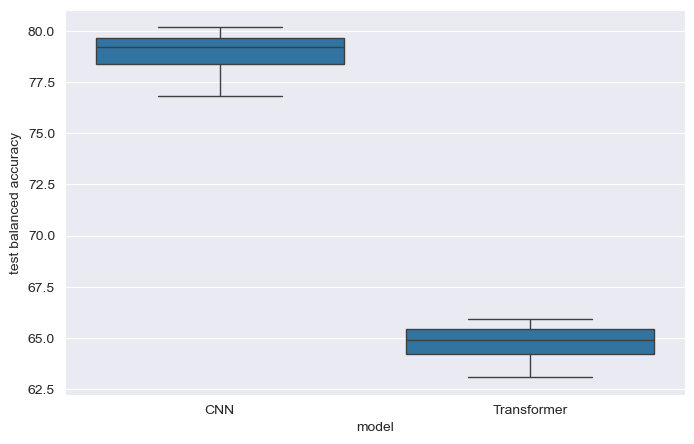

In [2]:
all_classes_root_dir = "output/history/without_unknown/final"
models = ["CNN", "Transformer"]
x_label = "model"
plot_results(all_classes_root_dir, models, x_label, use_balanced_accuracy=True)

## 2 classes

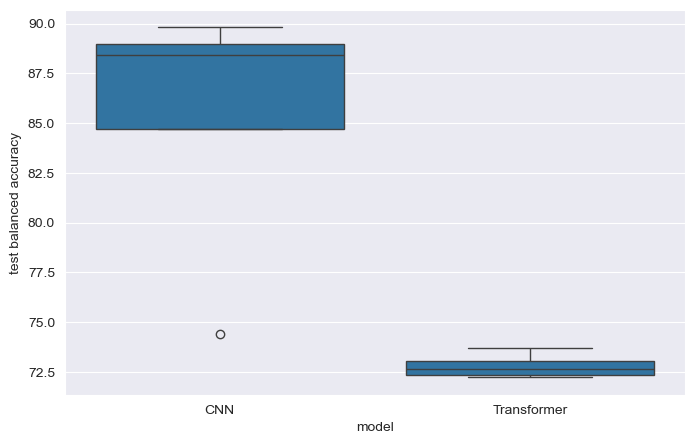

In [3]:
all_classes_root_dir = "output/history/binary/final"
models = ["CNN", "Transformer"]
x_label = "model"
plot_results(all_classes_root_dir, models, x_label, use_balanced_accuracy=True)

## Single models

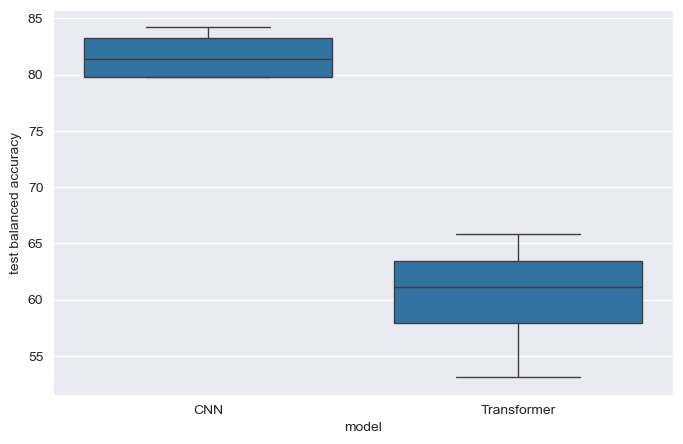

In [2]:
all_classes_root_dir = "output/history/all_classes/final"
models = ["CNN", "Transformer"]
x_label = "model"
plot_results(all_classes_root_dir, models, x_label, use_balanced_accuracy=True)

## Composite models

In [20]:
data_path = "data/train/audio_transformed"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 1
n_workers = 4
prefetch_factor = 2 if n_workers > 0 else None
persistent_workers = True if n_workers > 0 else False

In [ ]:
# all classes
test_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TEST)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

# binary
# binary_test_dataset = BinaryDataset(data_path, set_type=SpectrogramDataset.TEST)
# binary_test_loader = DataLoader(binary_test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

In [9]:
# collecting labels
X = []
labels = []
for x, y in test_loader:
    X.append(x)
    labels.append(y)
    
# binary_labels = []
# for x, y in binary_test_loader:
#     binary_labels.append(y)

In [100]:
from CNN import AudioClassifier
from transformer import SpeechTransformer

d_model = 128
nhead = 8
num_layers = 2

def init_transformer_binary():
    return SpeechTransformer(num_classes=2, d_model=d_model, nhead=nhead, num_layers=num_layers)

def init_transformer():
    return SpeechTransformer(num_classes=10, d_model=d_model, nhead=nhead, num_layers=num_layers)

def init_transformer_all():
    return SpeechTransformer(num_classes=11, d_model=d_model, nhead=nhead, num_layers=num_layers)

def init_cnn_binary():
     return AudioClassifier(num_classes=2)

def init_cnn():
     return AudioClassifier(num_classes=10)

def init_cnn_all():
     return AudioClassifier(num_classes=11)

In [108]:
classification_model = init_cnn_all()
classification_model.to(device)
# classification_model.load_state_dict(torch.load(classification_model_path, weights_only=True))

AudioClassifier(
  (conv1): Conv1d(81, 512, kernel_size=(5,), stride=(1,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (conv3): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.3, inplace=False)
  (bilstm1): LSTM(256, 128, batch_first=True, bidirectional=True)
  (drop4): Dropout(p=0.3, inplace=False)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bilstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (drop5): Dropout(p=0.3, inplace=False)
  (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): Ada

In [76]:
# loading filtering model
filtering_model = init_cnn_binary()
filtering_model.to(device)
model_path = "output/models/binary/final/cnn/cnn_1.pth"
filtering_model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [77]:
# using filtering model to remove unknown
preliminary_prediction = []
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    filtering_model.eval()
    with torch.no_grad():
        output = filtering_model(x)
        _, predicted = torch.max(output, 1)
        preliminary_prediction.append(predicted.cpu())

In [78]:
# mapping unknown
prediction = preliminary_prediction.copy()
for i in range(len(prediction)):
    if preliminary_prediction[i] == 1:
        prediction[i] = torch.tensor([10])

In [79]:
# loading classification model
classification_model = init_cnn()
classification_model.to(device)
model_path = "output/models/without_unknown/final/cnn/cnn_1.pth"
classification_model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [80]:
# final prediction
i = -1
for x, y in test_loader:
    i += 1
    x, y = x.to(device), y.to(device)
    if prediction[i] == 10:
        continue # the observation was filtered out by the first model
    classification_model.eval()
    with torch.no_grad():
        output = classification_model(x)
        _, predicted = torch.max(output, 1)
        prediction[i] = predicted.cpu()        

In [81]:
balanced_accuracy_score(labels, prediction)

0.746305944310821

In [95]:
def assess_model(test_loader, init_filtering_model, filtering_model_path, init_classification_model, classification_model_path):
    # extracting labels
    true_labels = []
    for x, y in test_loader:
        true_labels.append(y)
    
    # loading filtering model
    filtering_model = init_filtering_model()
    filtering_model.to(device)
    filtering_model.load_state_dict(torch.load(filtering_model_path, weights_only=True))
    
    # using filtering model to remove unknown
    preliminary_prediction = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        filtering_model.eval()
        with torch.no_grad():
            output = filtering_model(x)
            _, predicted = torch.max(output, 1)
            preliminary_prediction.append(predicted.cpu())
            
    # mapping unknown
    prediction = preliminary_prediction.copy()
    for i in range(len(prediction)):
        if preliminary_prediction[i] == 1:
            prediction[i] = torch.tensor([10])
            
    # loading classification model
    classification_model = init_classification_model()
    classification_model.to(device)
    classification_model.load_state_dict(torch.load(classification_model_path, weights_only=True))
    
    # final prediction
    i = -1
    for x, y in test_loader:
        i += 1
        x, y = x.to(device), y.to(device)
        if prediction[i] == 10:
            continue # the observation was filtered out by the first model
        classification_model.eval()
        with torch.no_grad():
            output = classification_model(x)
            _, predicted = torch.max(output, 1)
            prediction[i] = predicted.cpu()
                
    return balanced_accuracy_score(true_labels, prediction)

In [96]:
def assess_models(history_path, test_loader, init_filtering_model, filtering_model_path, init_classification_model, classification_model_path):
    # results = []
    for i in range(4):
        filtering_model_path_idx = add_prefix_to_path(filtering_model_path, i+1)
        classification_model_path_idx = add_prefix_to_path(classification_model_path, i+1)
        history_path_idx = add_prefix_to_path(history_path, i+1) # for saving results
        
        res = assess_model(test_loader, init_filtering_model, filtering_model_path_idx, init_classification_model, classification_model_path_idx)
        # results.append(res)
        
        training_history = {}
        training_history["accuracy_test"] = None
        training_history["loss_test"] = None
        training_history["balanced_accuracy_test"] = res

        save(training_history, history_path_idx)
    # return results

## CNN - CNN

In [97]:
history_dir = "output/history/ensemble/final/cnnbin_cnnwo"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/binary/final/cnn/cnn.pth"
classification_model_path = "output/models/without_unknown/final/cnn/cnn.pth"
assess_models(history_path, test_loader, init_cnn_binary, filtering_model_path, init_cnn, classification_model_path)

# CNN - CNN full

In [109]:
history_dir = "output/history/ensemble/final/cnnbin_cnnfull"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/binary/final/cnn/cnn.pth"
classification_model_path = "output/models/all_classes/final/cnn/cnn.pth"
assess_models(history_path, test_loader, init_cnn_binary, filtering_model_path, init_cnn_all, classification_model_path)

## CNN - TR

In [110]:
history_dir = "output/history/ensemble/final/cnnbin_trwo"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/binary/final/cnn/cnn.pth"
classification_model_path = "output/models/without_unknown/final/transformer/transformer.pth"
assess_models(history_path, test_loader, init_cnn_binary, filtering_model_path, init_transformer, classification_model_path)

## CNN - TR full

In [111]:
history_dir = "output/history/ensemble/final/cnnbin_trfull"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/binary/final/cnn/cnn.pth"
classification_model_path = "output/models/all_classes/final/transformer/transformer.pth"
assess_models(history_path, test_loader, init_cnn_binary, filtering_model_path, init_transformer_all, classification_model_path)

## CNN full - CNN full?

In [112]:
history_dir = "output/history/ensemble/final/cnnfull_cnnfull"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/all_classes/final/cnn/cnn.pth"
classification_model_path = "output/models/all_classes/final/cnn/cnn.pth"
assess_models(history_path, test_loader, init_cnn_all, filtering_model_path, init_cnn_all, classification_model_path)

## TR - TR

In [113]:
history_dir = "output/history/ensemble/final/trbin_trwo"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/binary/final/transformer/transformer.pth"
classification_model_path = "output/models/without_unknown/final/transformer/transformer.pth"
assess_models(history_path, test_loader, init_transformer_binary, filtering_model_path, init_transformer, classification_model_path)

## TR - TR full

In [114]:
history_dir = "output/history/ensemble/final/trbin_trfull"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/binary/final/transformer/transformer.pth"
classification_model_path = "output/models/all_classes/final/transformer/transformer.pth"
assess_models(history_path, test_loader, init_transformer_binary, filtering_model_path, init_transformer_all, classification_model_path)

## TR - CNN

In [115]:
history_dir = "output/history/ensemble/final/trbin_cnnwo"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/binary/final/transformer/transformer.pth"
classification_model_path = "output/models/without_unknown/final/cnn/cnn.pth"
assess_models(history_path, test_loader, init_transformer_binary, filtering_model_path, init_cnn, classification_model_path)

## TR - CNN full

In [117]:
history_dir = "output/history/ensemble/final/trbin_cnnfull"
os.makedirs(history_dir, exist_ok=True)
history_path = history_dir + "/history.pkl"

filtering_model_path = "output/models/binary/final/transformer/transformer.pth"
classification_model_path = "output/models/all_classes/final/cnn/cnn.pth"
assess_models(history_path, test_loader, init_transformer_binary, filtering_model_path, init_cnn_all, classification_model_path)

## Ensemble comparison

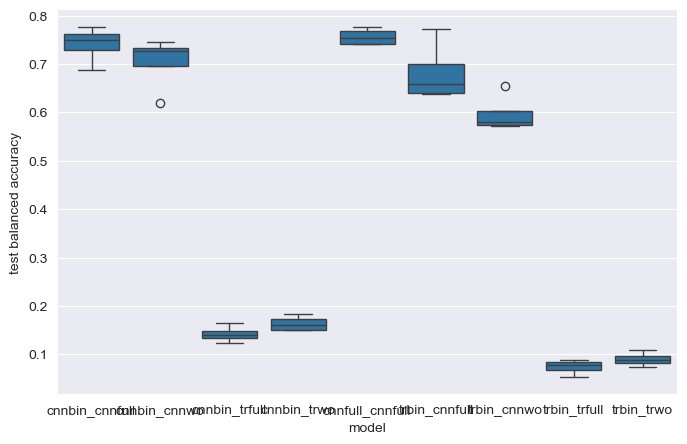

In [130]:
ensemble_root_dir = "output/history/ensemble/final"
models = ["cnnbin_cnnfull", "cnnbin_cnnwo", "cnnbin_trfull", "cnnbin_trwo", "cnnfull_cnnfull", "trbin_cnnfull", "trbin_cnnwo", "trbin_trfull", "trbin_trwo"]
x_label = "model"
plot_results(ensemble_root_dir, models, x_label, use_balanced_accuracy=True)